In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# **Lectura de base de datos**

In [2]:
df = pd.read_csv('datasets/MPDbConvCellCANoRareEarthsNoElem.csv')
df

,id,Formule,BG,IM,CA,a,b,c,alpha,beta,gamma,contains_rare_earth,is_element,num_of_elements
0,mp-239,BaS3,1.3913,False,62546.518850,6.951955,6.951955,4.216011,90.0,90.000000,90.0,False,False,2
1,mp-241,CdF2,2.8977,False,1582.356544,5.401038,5.401038,5.401038,90.0,90.000000,90.0,False,False,2
2,mp-252,BeTe,2.0173,False,10109.303511,5.662918,5.662918,5.662918,90.0,90.000000,90.0,False,False,2
3,mp-315,PbF2,4.3938,False,2088.183714,5.915897,5.915897,5.915897,90.0,90.000000,90.0,False,False,2
4,mp-361,Cu2O,0.5127,False,241827.782769,4.246699,4.246699,4.246699,90.0,90.000000,90.0,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,mp-998552,BaHfO3,3.5394,False,2506.196783,4.169567,4.169567,4.170377,90.0,90.000000,90.0,False,False,3
651,mp-998739,MgTlF3,4.2135,False,2006.880778,5.763086,5.766610,4.077045,90.0,90.000000,90.0,False,False,3
652,mp-998745,TlZnF3,3.9179,False,2366.630022,4.117342,4.115025,4.124462,90.0,90.035864,90.0,False,False,3
653,mp-998761,TlNiF3,3.4347,False,14303.261275,4.087358,4.087358,4.087358,90.0,90.000000,90.0,False,False,3


## **Constantes de Sb2Se3**

In [3]:
# Using the Pbnm space group
ase_a = 11.62
ase_b = 11.77
ase_c = 3.962
ase_alpha = 90
ase_beta = 90
ase_gamma = 90

ase_abc = (ase_a,ase_b,ase_c)
ase_angles = (ase_alpha,ase_beta,ase_gamma)

## **Algoritmo de cálculo de lattice mismatch (crecimiento perpendicular de cadenas)**

In [4]:
def calc_lattice_mismatch_perp(row):

    #Get lattice data
    abc = (row['a'],row['b'],row['c'])
    angles = (row['alpha'],row['beta'],row['gamma'])

    #Round to 5 decimals
    abc = tuple(map(
        lambda x: round(x, 5),
        abc
    ))
    angles = tuple(map(
        lambda x: round(x, 5),
        angles
    ))

    #Handle the case for hexagonal structures
    if angles[2] == 120:
        f = 2*abs(abc[0]-ase_a)/(abc[0]+ase_a)
        return f #We do not check any other combination
                 #of lattice parameters.
    
    #Find consistent angles
    angle_indices = [] #To track the chosen angle(s)
    for i in range(3):
        if ase_angles[2] == angles[i]:
            angle_indices.append(i)
    
    #Return NaN if there's no match
    if len(angle_indices) == 0: return pd.NA
    
    #Execute calculation.
    #f_a, f_b: lattice mismatch along the a
    #and b axes of ASe, respectively.

    #But first look: for a given angle index
    #we can add and subtract 1 to get the
    #corresponding lattice constants.
    #       alpha  beta  gamma  alpha  beta  gamma
    #         a      b      c    a      b     c

    f = 0 #final lattice mismatch value
    possible_values_of_f = []

    for angle_index in angle_indices:

        #We use modulo 3 to avoid an
        #IndexError! (out of range)
        #Yes, it works with the index = -1, too!
        '''f_a1 = abs(
            abc[(angle_index-1)%3]-ase_a
            )/ase_a
        f_b1 = abs(
            abc[(angle_index+1)%3]-ase_b
            )/ase_b''' #This was a previous formula.
        f_a1 = 2*abs(
                abc[(angle_index-1)%3]-ase_a
            ) /(abc[(angle_index-1)%3]+ase_a)
        f_b1 = 2*abs(
                abc[(angle_index+1)%3]-ase_b
            ) /(abc[(angle_index+1)%3]+ase_b)
        
        #We swap the material's lattice constants:
        '''f_a2 = abs(
            abc[(angle_index+1)%3]-ase_a
            )/ase_a
        f_b2 = abs(
            abc[(angle_index-1)%3]-ase_b
            )/ase_b'''
        f_a2 = 2*abs(
                abc[(angle_index+1)%3]-ase_a
            ) /(abc[(angle_index+1)%3]+ase_a)
        f_b2 = 2*abs(
                abc[(angle_index-1)%3]-ase_b
            ) /(abc[(angle_index-1)%3]+ase_b)
        
        possible_values_of_f.append(f_a1)
        possible_values_of_f.append(f_b1)
        possible_values_of_f.append(f_a2)
        possible_values_of_f.append(f_b2)

    #Determine f
    f = min(*possible_values_of_f)

    return f


## **Aplicación a la base de datos**

In [5]:
df['latt_mis_perp'] = df.apply(
    func=calc_lattice_mismatch_perp,
    axis=1
)

df

,id,Formule,BG,IM,CA,a,b,c,alpha,beta,gamma,contains_rare_earth,is_element,num_of_elements,latt_mis_perp
0,mp-239,BaS3,1.3913,False,62546.518850,6.951955,6.951955,4.216011,90.0,90.000000,90.0,False,False,2,0.502698
1,mp-241,CdF2,2.8977,False,1582.356544,5.401038,5.401038,5.401038,90.0,90.000000,90.0,False,False,2,0.730738
2,mp-252,BeTe,2.0173,False,10109.303511,5.662918,5.662918,5.662918,90.0,90.000000,90.0,False,False,2,0.689360
3,mp-315,PbF2,4.3938,False,2088.183714,5.915897,5.915897,5.915897,90.0,90.000000,90.0,False,False,2,0.650563
4,mp-361,Cu2O,0.5127,False,241827.782769,4.246699,4.246699,4.246699,90.0,90.000000,90.0,False,False,2,0.929406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,mp-998552,BaHfO3,3.5394,False,2506.196783,4.169567,4.169567,4.170377,90.0,90.000000,90.0,False,False,3,0.943564
651,mp-998739,MgTlF3,4.2135,False,2006.880778,5.763086,5.766610,4.077045,90.0,90.000000,90.0,False,False,3,0.673322
652,mp-998745,TlZnF3,3.9179,False,2366.630022,4.117342,4.115025,4.124462,90.0,90.035864,90.0,False,False,3,0.952150
653,mp-998761,TlNiF3,3.4347,False,14303.261275,4.087358,4.087358,4.087358,90.0,90.000000,90.0,False,False,3,0.959122


In [6]:
df.to_csv('datasets/lattice_mismatch_results.csv',index=False)

In [7]:
df['latt_mis_perp'].sort_values()

152    0.000143
116    0.005921
300    0.006500
109    0.019509
354    0.020337
         ...   
235    1.212414
272    1.213933
104    1.230185
395    1.237258
29     1.288889
Name: latt_mis_perp, Length: 655, dtype: float64

# Filtered dataset

### Criteria:
1. Band gap: from 1.12 eV (CdS on MP) to 3 eV (slightly above max value of gap of TiO2 on MP).
2. Absorption coeff: no restrictions.
3. Lattice mismatch: less than 114% for perpendicularly grown epilayers. (Reported f for ZnO/Sb2Se3.)

In [8]:
filtered_df = df[(1.12 <= df['BG']) & (df['BG'] <= 3)]
filtered_df = filtered_df[filtered_df['latt_mis_perp'] <= 1.14]

## With perp. growth

C:\Users\Andre\AppData\Local\Temp\ipykernel_26284\3372157803.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



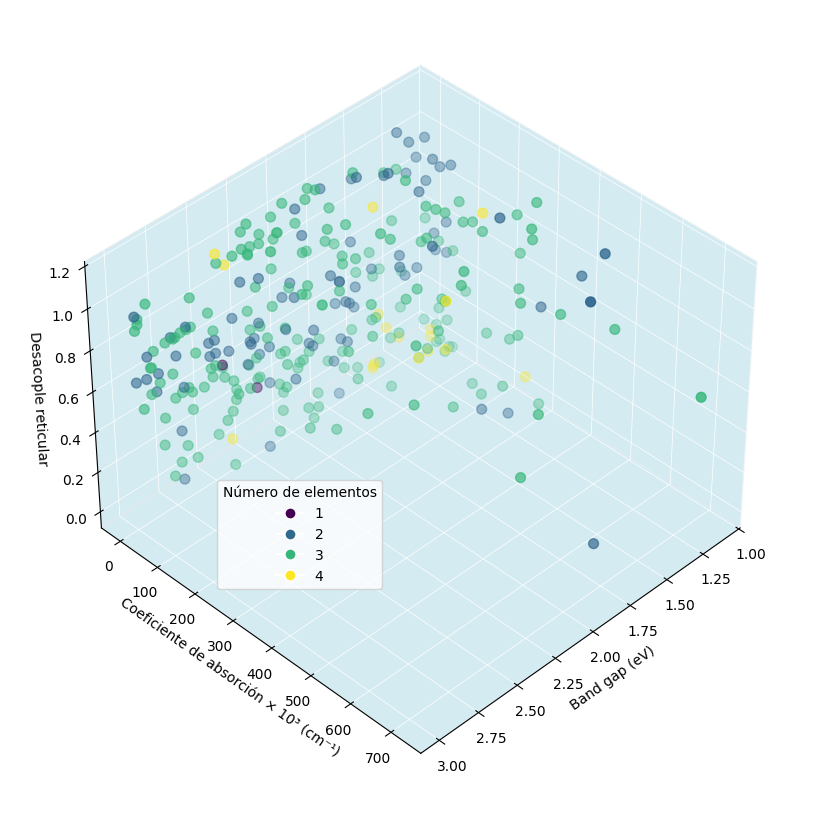

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

# Set labels
ax.set_xlabel('Band gap (eV)')
ax.set_ylabel('Coeficiente de absorción \u00d7 10\u00B3 (cm\u207B\u00B9)')
ax.set_zlabel('Desacople reticular')
ax.set_box_aspect(None, zoom=0.90)

# 1. Color and opacity of markers by additional columns
# Replace 'color_column' and 'opacity_column' with your actual column names
# Normalize opacity values to 0-1 range if needed
opacity_values = filtered_df['CA'].values  # Replace 'opacity_column' with your column name
# If your opacity column needs normalization (e.g., values are 0-100), uncomment next line:

p = opacity_values.min()
q = opacity_values.max()
p_p = 0.7 # Custom opacity minimum value
opacity_values = 1 + (((p_p-1)/(p-q))*(opacity_values - q))  # Normalize to 0-1

# 1. Color markers by additional column (replace 'color_column' with your actual column name)
# You can use different colormaps like 'viridis', 'plasma', 'coolwarm', 'jet', etc.


# Normalize color values
norm = Normalize(vmin=filtered_df['num_of_elements'].min(), vmax=filtered_df['num_of_elements'].max())
cmap = get_cmap('viridis')
colors_mapped = cmap(norm(filtered_df['num_of_elements'].values))  # RGBA

# Replace alpha channel with your opacity values
colors_mapped[:, 3] = opacity_values  # Set the alpha for each point

# Now pass these full RGBA colors
scatter = ax.scatter(
    xs=filtered_df['BG'].values,
    ys=filtered_df['CA'].values / 1e3,
    zs=filtered_df['latt_mis_perp'].values,
    c=colors_mapped,  # Pass RGBA colors directly
    marker='o',
    s=50
)


# Add legend instead of colorbar
# This approach works if your color column contains categorical/discrete values
unique_values = np.sort(filtered_df['num_of_elements'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Use same colormap

# Create legend handles
legend_handles = []
for i, value in enumerate(unique_values):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=colors[i], markersize=8, 
                                   label=f'{value}'))

# Add legend
ax.legend(handles=legend_handles, title='Número de elementos', 
          loc='upper left', bbox_to_anchor=(0.25, 0.42))

# 2. Adjust viewing perspective (elevation and azimuth angles)
ax.view_init(elev=40, azim=45)  # Adjust these values as needed
# elev: elevation angle (vertical rotation, -90 to 90)
# azim: azimuth angle (horizontal rotation, 0 to 360)

# 4. Change the color of the three planes (panes)
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.xaxis.pane.set_facecolor('lightblue')    # X-plane color
ax.yaxis.pane.set_facecolor('lightblue')  # Y-plane color
ax.zaxis.pane.set_facecolor('lightblue')  # Z-plane color

# 5. Change opacity of grid lines (not the planes themselves)
# Set grid line properties for each axis
ax.xaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.yaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.zaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

fig.savefig('figures/scatter3d_1.svg')

C:\Users\Andre\AppData\Local\Temp\ipykernel_26284\981323412.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


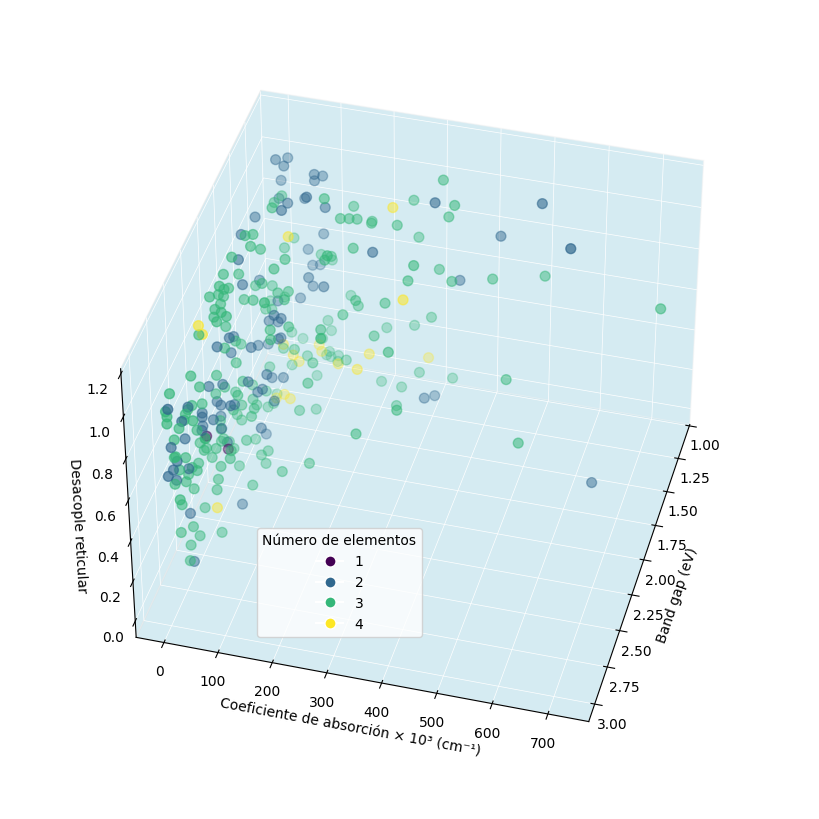

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

# Set labels
ax.set_xlabel('Band gap (eV)')
ax.set_ylabel('Coeficiente de absorción \u00d7 10\u00B3 (cm\u207B\u00B9)')
ax.set_zlabel('Desacople reticular')
ax.set_box_aspect(None, zoom=0.90)

# 1. Color and opacity of markers by additional columns
# Replace 'color_column' and 'opacity_column' with your actual column names
# Normalize opacity values to 0-1 range if needed
opacity_values = filtered_df['CA'].values  # Replace 'opacity_column' with your column name
# If your opacity column needs normalization (e.g., values are 0-100), uncomment next line:

p = opacity_values.min()
q = opacity_values.max()
p_p = 0.7 # Custom opacity minimum value
opacity_values = 1 + (((p_p-1)/(p-q))*(opacity_values - q))  # Normalize to 0-1

# 1. Color markers by additional column (replace 'color_column' with your actual column name)
# You can use different colormaps like 'viridis', 'plasma', 'coolwarm', 'jet', etc.


# Normalize color values
norm = Normalize(vmin=filtered_df['num_of_elements'].min(), vmax=filtered_df['num_of_elements'].max())
cmap = get_cmap('viridis')
colors_mapped = cmap(norm(filtered_df['num_of_elements'].values))  # RGBA

# Replace alpha channel with your opacity values
colors_mapped[:, 3] = opacity_values  # Set the alpha for each point

# Now pass these full RGBA colors
scatter = ax.scatter(
    xs=filtered_df['BG'].values,
    ys=filtered_df['CA'].values / 1e3,
    zs=filtered_df['latt_mis_perp'].values,
    c=colors_mapped,  # Pass RGBA colors directly
    marker='o',
    s=50
)


# Add legend instead of colorbar
# This approach works if your color column contains categorical/discrete values
unique_values = np.sort(filtered_df['num_of_elements'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Use same colormap

# Create legend handles
legend_handles = []
for i, value in enumerate(unique_values):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=colors[i], markersize=8, 
                                   label=f'{value}'))

# Add legend
ax.legend(handles=legend_handles, title='Número de elementos', 
          loc='upper left', bbox_to_anchor=(0.3, 0.36))

# 2. Adjust viewing perspective (elevation and azimuth angles)
ax.view_init(elev=40, azim=15)  # Adjust these values as needed
# elev: elevation angle (vertical rotation, -90 to 90)
# azim: azimuth angle (horizontal rotation, 0 to 360)

# 4. Change the color of the three planes (panes)
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.xaxis.pane.set_facecolor('lightblue')    # X-plane color
ax.yaxis.pane.set_facecolor('lightblue')  # Y-plane color
ax.zaxis.pane.set_facecolor('lightblue')  # Z-plane color

# 5. Change opacity of grid lines (not the planes themselves)
# Set grid line properties for each axis
ax.xaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.yaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.zaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

fig.savefig('figures/scatter3d_2.svg')

In [11]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=filtered_df['BG'],
    y=filtered_df['CA'],
    z=filtered_df['latt_mis_perp'],
    mode='markers',
    marker=dict(size=5, color=filtered_df['num_of_elements'], colorscale='Viridis', opacity=0.8),
    text=filtered_df['Formule'],
    hoverinfo='text+x+y+z'
)])

fig.update_layout(scene=dict(
    xaxis_title='Band gap (eV)',
    yaxis_title='Absorption coeff. (cm-1)',
    zaxis_title='Lattice mismatch (perp.)'
    ),
    margin=dict(l=0,r=0,b=0,t=0)
)
fig.show()
fig.write_image("figures/scatter3d.svg")


## Selecting binary compounds only

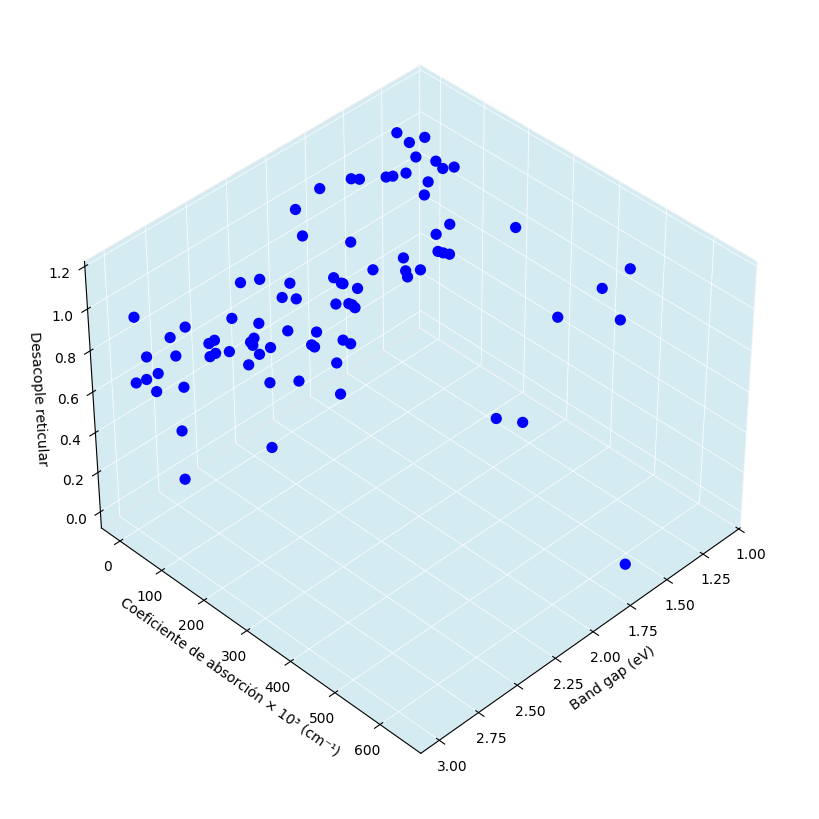

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

# Set labels
ax.set_xlabel('Band gap (eV)')
ax.set_ylabel('Coeficiente de absorción \u00d7 10\u00B3 (cm\u207B\u00B9)')
ax.set_zlabel('Desacople reticular')
ax.set_box_aspect(None, zoom=0.90)

# Now pass these full RGBA colors
scatter = ax.scatter(
    xs=filtered_df[filtered_df['num_of_elements'] == 2]['BG'].values,
    ys=filtered_df[filtered_df['num_of_elements'] == 2]['CA'].values / 1e3,
    zs=filtered_df[filtered_df['num_of_elements'] == 2]['latt_mis_perp'].values,
    c='blue',
    alpha=1,
    marker='o',
    s=50
)

# Add legend instead of colorbar
# This approach works if your color column contains categorical/discrete values
unique_values = np.sort(filtered_df['num_of_elements'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Use same colormap

# Create legend handles
legend_handles = []
for i, value in enumerate(unique_values):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=colors[i], markersize=8, 
                                   label=f'{value}'))

'''# Add legend
ax.legend(handles=legend_handles, title='Número de elementos', 
          loc='upper left', bbox_to_anchor=(0.25, 0.42))'''

# 2. Adjust viewing perspective (elevation and azimuth angles)
ax.view_init(elev=40, azim=45)  # Adjust these values as needed
# elev: elevation angle (vertical rotation, -90 to 90)
# azim: azimuth angle (horizontal rotation, 0 to 360)

# 4. Change the color of the three planes (panes)
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.xaxis.pane.set_facecolor('lightblue')    # X-plane color
ax.yaxis.pane.set_facecolor('lightblue')  # Y-plane color
ax.zaxis.pane.set_facecolor('lightblue')  # Z-plane color

# 5. Change opacity of grid lines (not the planes themselves)
# Set grid line properties for each axis
ax.xaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.yaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.zaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

fig.savefig('figures/scatter3d_3.svg')

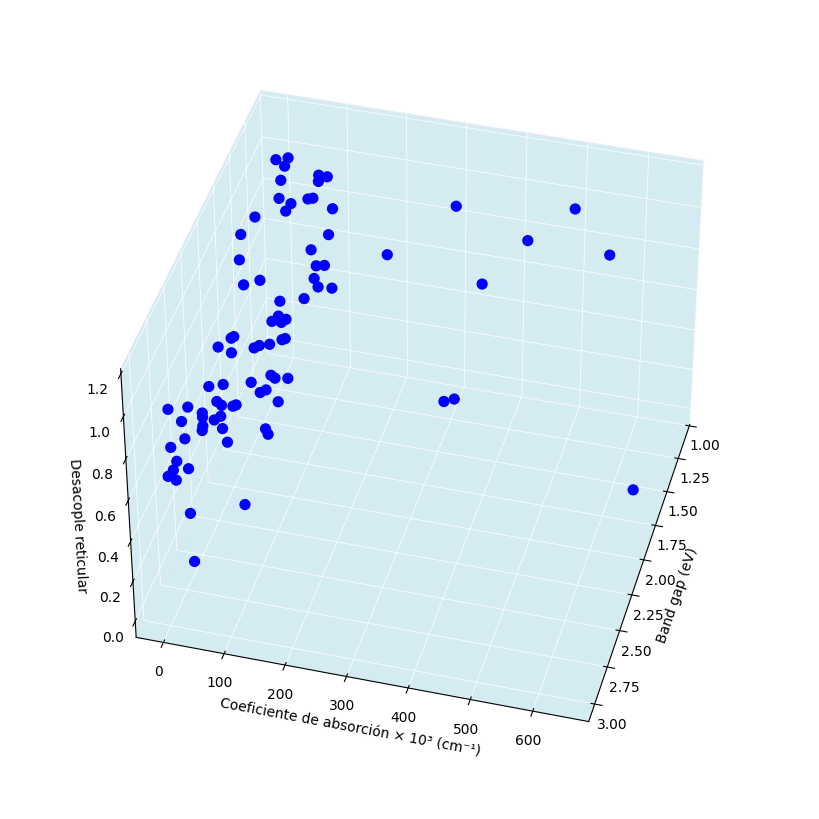

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

# Set labels
ax.set_xlabel('Band gap (eV)')
ax.set_ylabel('Coeficiente de absorción \u00d7 10\u00B3 (cm\u207B\u00B9)')
ax.set_zlabel('Desacople reticular')
ax.set_box_aspect(None, zoom=0.90)

# Now pass these full RGBA colors
scatter = ax.scatter(
    xs=filtered_df[filtered_df['num_of_elements'] == 2]['BG'].values,
    ys=filtered_df[filtered_df['num_of_elements'] == 2]['CA'].values / 1e3,
    zs=filtered_df[filtered_df['num_of_elements'] == 2]['latt_mis_perp'].values,
    c='blue',
    alpha=1,
    marker='o',
    s=50
)

# Add legend instead of colorbar
# This approach works if your color column contains categorical/discrete values
unique_values = np.sort(filtered_df['num_of_elements'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Use same colormap

# Create legend handles
legend_handles = []
for i, value in enumerate(unique_values):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=colors[i], markersize=8, 
                                   label=f'{value}'))

'''# Add legend
ax.legend(handles=legend_handles, title='Número de elementos', 
          loc='upper left', bbox_to_anchor=(0.25, 0.42))'''

# 2. Adjust viewing perspective (elevation and azimuth angles)
ax.view_init(elev=40, azim=15)  # Adjust these values as needed
# elev: elevation angle (vertical rotation, -90 to 90)
# azim: azimuth angle (horizontal rotation, 0 to 360)

# 4. Change the color of the three planes (panes)
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.xaxis.pane.set_facecolor('lightblue')    # X-plane color
ax.yaxis.pane.set_facecolor('lightblue')  # Y-plane color
ax.zaxis.pane.set_facecolor('lightblue')  # Z-plane color

# 5. Change opacity of grid lines (not the planes themselves)
# Set grid line properties for each axis
ax.xaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.yaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)
ax.zaxis._axinfo['grid'].update(color='white', linewidth=0.5, alpha=0.3)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

fig.savefig('figures/scatter3d_4.svg')

In [14]:
aux_df = filtered_df[filtered_df['num_of_elements'] == 2].sort_values(by='latt_mis_perp',ascending=True)

display(aux_df)

,id,Formule,BG,IM,CA,a,b,c,alpha,beta,gamma,contains_rare_earth,is_element,num_of_elements,latt_mis_perp
152,mp-22859,HgI,1.6426,False,642451.182664,5.070441,5.070441,11.771679,90.0,90.0,90.0,False,False,2,0.000143
185,mp-23177,HgBr,2.2557,False,45959.263368,4.743077,4.743077,11.286350,90.0,90.0,90.0,False,False,2,0.029132
16,mp-706,HgF,1.7704,False,35411.833792,3.658953,3.658953,11.045499,90.0,90.0,90.0,False,False,2,0.050694
157,mp-22897,HgCl,2.7243,False,11323.398673,4.529055,4.529055,11.043827,90.0,90.0,90.0,False,False,2,0.050845
186,mp-23202,InI,1.3412,False,313509.146667,4.860244,12.865264,4.833636,90.0,90.0,90.0,False,False,2,0.088918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,mp-762,PtS2,1.5467,False,582625.696898,3.548742,3.548742,5.597067,90.0,90.0,120.0,False,False,2,1.064196
64,mp-1591,Al4C3,1.3154,False,12390.161172,3.333032,3.333032,24.915626,90.0,90.0,120.0,False,False,2,1.108400
68,mp-1821,WSe2,1.4465,False,324073.678176,3.319933,3.319933,13.737187,90.0,90.0,120.0,False,False,2,1.111126
22,mp-804,GaN,1.7265,False,70831.691949,3.188930,3.188930,5.192357,90.0,90.0,120.0,False,False,2,1.138647


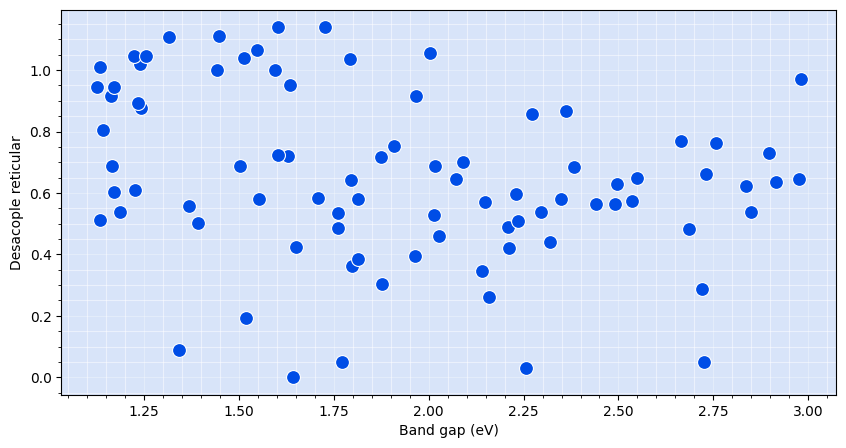

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(alpha=0.3)
ax.grid(which='both',axis='both', color='white')
ax.grid(which='minor',axis='both',alpha=0.5,zorder=-1)
ax.set_facecolor((217/256,229/256,250/256))

ax = sns.scatterplot(
    data=aux_df,
    x='BG',
    y='latt_mis_perp',
    #hue='crystal_struct',
    s=100,
    color=(0,0.3,0.9)
)

ax.set_xlabel('Band gap (eV)')
ax.set_ylabel('Desacople reticular')
#ax.legend(loc='upper right', bbox_to_anchor=(.93, 0.99))
fig.savefig('figures/mismatch_vs_bandgap.svg')


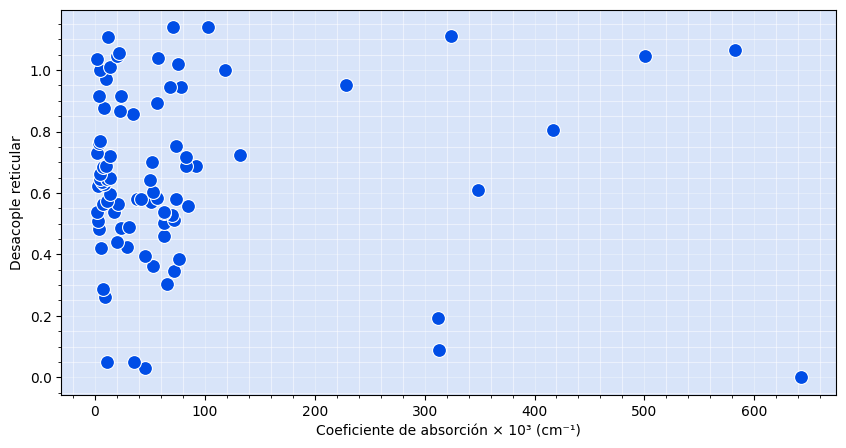

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(alpha=0.3)
ax.grid(which='both',axis='both', color='white')
ax.grid(which='minor',axis='both',alpha=0.5,zorder=-1)
ax.set_facecolor((217/256,229/256,250/256))

aux_df['CA'] = aux_df['CA'] / 1e3

ax = sns.scatterplot(
    data=aux_df,
    x='CA',
    y='latt_mis_perp',
    #hue='crystal_struct',
    s=100,
    color=(0,0.3,0.9)
)

ax.set_xlabel('Coeficiente de absorción \u00d7 10\u00B3 (cm\u207B\u00B9)')
ax.set_ylabel('Desacople reticular')
#ax.legend(loc='upper right', bbox_to_anchor=(.93, 0.99))
fig.savefig('figures/mismatch_vs_absorp_coeff.svg')


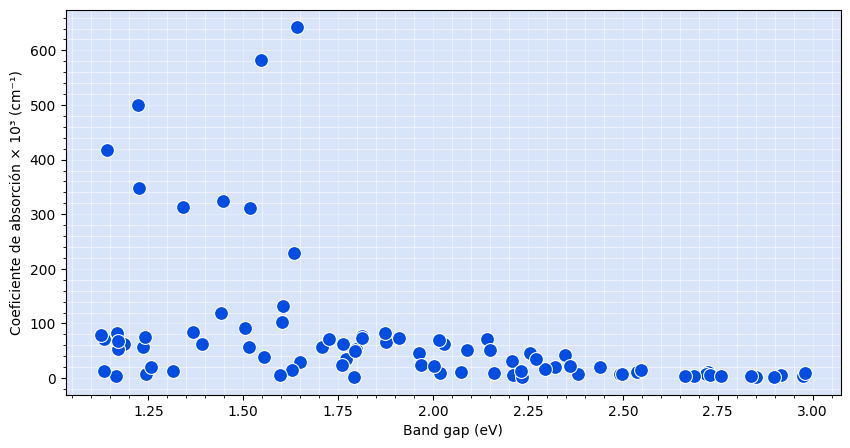

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(alpha=0.3)
ax.grid(which='both',axis='both', color='white')
ax.grid(which='minor',axis='both',alpha=0.5,zorder=-1)
ax.set_facecolor((217/256,229/256,250/256))

ax = sns.scatterplot(
    data=aux_df,
    x='BG',
    y='CA',
    #hue='crystal_struct',
    s=100,
    color=(0,0.3,0.9)
)

ax.set_ylabel('Coeficiente de absorción \u00d7 10\u00B3 (cm\u207B\u00B9)')
ax.set_xlabel('Band gap (eV)')
#ax.legend(loc='upper right', bbox_to_anchor=(.93, 0.99))
fig.savefig('figures/absorp_coeff_vs_bandgap.svg')


# Sorting by lattice mismatch value and exporting to csv

In [18]:
aux_df = filtered_df[filtered_df['num_of_elements'] == 2].sort_values(by='latt_mis_perp',ascending=True)

display(aux_df)

aux_df.to_csv('datasets/filter_results.csv',index=False)

,id,Formule,BG,IM,CA,a,b,c,alpha,beta,gamma,contains_rare_earth,is_element,num_of_elements,latt_mis_perp
152,mp-22859,HgI,1.6426,False,642451.182664,5.070441,5.070441,11.771679,90.0,90.0,90.0,False,False,2,0.000143
185,mp-23177,HgBr,2.2557,False,45959.263368,4.743077,4.743077,11.286350,90.0,90.0,90.0,False,False,2,0.029132
16,mp-706,HgF,1.7704,False,35411.833792,3.658953,3.658953,11.045499,90.0,90.0,90.0,False,False,2,0.050694
157,mp-22897,HgCl,2.7243,False,11323.398673,4.529055,4.529055,11.043827,90.0,90.0,90.0,False,False,2,0.050845
186,mp-23202,InI,1.3412,False,313509.146667,4.860244,12.865264,4.833636,90.0,90.0,90.0,False,False,2,0.088918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,mp-762,PtS2,1.5467,False,582625.696898,3.548742,3.548742,5.597067,90.0,90.0,120.0,False,False,2,1.064196
64,mp-1591,Al4C3,1.3154,False,12390.161172,3.333032,3.333032,24.915626,90.0,90.0,120.0,False,False,2,1.108400
68,mp-1821,WSe2,1.4465,False,324073.678176,3.319933,3.319933,13.737187,90.0,90.0,120.0,False,False,2,1.111126
22,mp-804,GaN,1.7265,False,70831.691949,3.188930,3.188930,5.192357,90.0,90.0,120.0,False,False,2,1.138647


In [19]:
aux_df[aux_df['Formule']=='CdS']

,id,Formule,BG,IM,CA,a,b,c,alpha,beta,gamma,contains_rare_earth,is_element,num_of_elements,latt_mis_perp
15,mp-672,CdS,1.125,False,78525.550978,4.168838,4.168838,6.779617,90.0,90.0,120.0,False,False,2,0.943851


In [20]:
filtered_df

,id,Formule,BG,IM,CA,a,b,c,alpha,beta,gamma,contains_rare_earth,is_element,num_of_elements,latt_mis_perp
0,mp-239,BaS3,1.3913,False,62546.518850,6.951955,6.951955,4.216011,90.0,90.000000,90.0,False,False,2,0.502698
1,mp-241,CdF2,2.8977,False,1582.356544,5.401038,5.401038,5.401038,90.0,90.000000,90.0,False,False,2,0.730738
2,mp-252,BeTe,2.0173,False,10109.303511,5.662918,5.662918,5.662918,90.0,90.000000,90.0,False,False,2,0.689360
5,mp-375,UO3,1.6350,False,228128.774945,4.135416,4.135416,4.135416,90.0,90.000000,90.0,False,False,2,0.950096
8,mp-441,Rb2Te,1.8766,False,65916.018982,8.562209,8.562209,8.562209,90.0,90.000000,90.0,False,False,2,0.303018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,mp-985586,Na3BrO,1.8815,False,49642.948092,4.533130,4.533130,4.533130,90.0,90.000000,90.0,False,False,3,0.877461
639,mp-985829,HfS2,1.2237,False,500327.678919,3.639664,3.639664,6.055562,90.0,90.000000,120.0,False,False,2,1.045939
643,mp-996959,LiAuO2,1.3059,False,207033.372214,4.209500,4.209500,10.612628,90.0,90.000000,90.0,False,False,3,0.090621
648,mp-997089,NaAuO2,1.1590,False,98118.982428,6.525207,3.022015,6.100229,90.0,118.139783,90.0,False,False,3,0.561558
